# 用MATLAB绘制GIF动图
一直以来，本人的打字速度都落后领导一个数量级，虽然本近视眼使用了专为中老年设计的拼音九键布局，但聊天的时候仍然感觉望尘莫及。在情侣之间，一个人说了十句话，另一个人才冒出来2个字，这是要出事的。

万幸的是有表情包，可以让我在聊天的时候先点上几个表情，赢得一点缓冲时间。

今天就写一写怎么用MATLAB制作动图，当然这个图拿来放进PPT里还是收进微信表情包，因图而异。

应该有不少人都看到过下面这个图：近半个世纪以来世界前十经济体的GDP变化。今天的主要任务就是用MATLAB画一个这样的图。
![GDP](Target.gif)

## 数据准备
我们直接在世界银行的网站上[下载GDP数据]((https://databank.worldbank.org/data/reports.aspx?source=2&series=NY.GDP.MKTP.CD&country=#))，选择右上角的下载，随意选一种文件格式下载。

将下载的数据解压之后，先浏览一下数据内容。虽然我下载的是.csv文件，但是严重建议先用文本编辑器(如Notepad++)打开看一下，因为Excel可能会把一些东西藏起来不让你看。

![DataView](DataView.PNG)

粗略看一下以后会发现数据文件的几个特点
* 以逗号为分隔符
* 文本和数值混合
* 有一些域是空的，用两个句点.表示了

遇到这些情况，MATLAB的csvread和dlmread函数基本可以放弃了，它们都适用于数值数据比较规整的情况，而这里..的域会直接造成dlmread报错。我们用一个更加高级的函数readtable来导入数据。


In [1]:
D = readtable('3cf5f990-cc87-43a8-b5e6-ab0e437d81cc_Data.csv');
D(1:10,1:6)


ans =

  10x6 table

      x___SeriesName          SeriesCode            CountryName         CountryCode      x1969_YR1969_         x1970_YR1970_   
    ___________________    ________________    _____________________    ___________    __________________    __________________

    'GDP (current US$)'    'NY.GDP.MKTP.CD'    'Afghanistan'            'AFG'          '1408888922.22222'    '1748886595.55556'
    'GDP (current US$)'    'NY.GDP.MKTP.CD'    'Albania'                'ALB'          '..'                  '..'              
    'GDP (current US$)'    'NY.GDP.MKTP.CD'    'Algeria'                'DZA'          '4257218772.15369'    '4863487492.65763'
    'GDP (current US$)'    'NY.GDP.MKTP.CD'    'American Samoa'         'ASM'          '..'                  '..'              
    'GDP (current US$)'    'NY.GDP.MKTP.CD'    'Andorra'                'AND'          '..'                  '78619206.0850963'
    'GDP (current US$)'    'NY.GDP.MKTP.CD'    'Angola'                 'AGO'    

我们看到，readtable直接给把每一列的名字，如SeriesName，SeriesCode，CountryName...等等都识别出来了(导入的时候的Warning说把每列的名字稍微改了一下，加了下划线使得命名合法)，这些列的数据可以直接通过结构体访问：

In [2]:
D.CountryName(1:3)
D.x1969_YR1969_(1:3)


ans =

  3x1 cell array

    {'Afghanistan'}
    {'Albania'    }
    {'Algeria'    }


ans =

  3x1 cell array

    {'1408888922.22222'}
    {'..'              }
    {'4257218772.15369'}




在这个数据里，我们要使用主要是国家名字和每一年的具体数据，可以看到CountryName是Cell array，每年的数据也是Cell array。一般情况下，如果某一列数据都是数值，那么readtable是可以直接将其转换成数值数据的，然而这个文件里，由于两个句点..的存在，readtable只能将其转变为string。转过来想一想，如果是csvread或者dlmread，这里直接就报错了，这就是为什么readtable比dlmread要高级厉害。

虽然readtable将其读入为string了，但是我们可以很容易将其转变为数值。

In [3]:
% apply to each column
D1 = varfun(@str2double,D);
D1(1:10,[3 5 6])
% apply to whole table
DD = str2double(D)


ans =

  10x3 table

    str2double_CountryName    str2double_x1969_YR1969_    str2double_x1970_YR1970_
    ______________________    ________________________    ________________________

    NaN                       1.4089e+09                  1.7489e+09              
    NaN                              NaN                         NaN              
    NaN                       4.2572e+09                  4.8635e+09              
    NaN                              NaN                         NaN              
    NaN                              NaN                  7.8619e+07              
    NaN                              NaN                         NaN              
    NaN                              NaN                         NaN              
    NaN                       3.1256e+10                  3.1584e+10              
    NaN                              NaN                         NaN              
    NaN                              NaN                        

上面的代码中，varfun，对D这个table的每一列(Variable)应用str2double这一函数。为什么不直接对整个table应用str2double呢？由于表格各种数据类型混合，无法识别的数据被转变成了NaN，str2double(D)直接返回了NaN。

按列执行变换之后，所有的数值都被识别了出来，无法转换成数值的都转换成了NaN。由于我们绘制GIF图只需要每一年GDP排名前十的国家，因此这里我们可以简单的将NaN替换为零，方便后面对数值排序。

In [4]:
D2 = fillmissing(D1,'constant',0);
D2(1:10,[3 5 6])


ans =

  10x3 table

    str2double_CountryName    str2double_x1969_YR1969_    str2double_x1970_YR1970_
    ______________________    ________________________    ________________________

    0                         1.4089e+09                  1.7489e+09              
    0                                  0                           0              
    0                         4.2572e+09                  4.8635e+09              
    0                                  0                           0              
    0                                  0                  7.8619e+07              
    0                                  0                           0              
    0                                  0                           0              
    0                         3.1256e+10                  3.1584e+10              
    0                                  0                           0              
    0                                  0                        

在进行下一步之前，我们需要注意数据中的一个坑。在世界银行的这个数据中，CountryName这一列不只包含了所有国家，还包含了各个地区/分组等，比如东亚，欧洲，中等收入国家等等。

好在这一列是先将所有国家按字母排序，再将所有地区等按字母排序，因此我们可以很容易的将所有国家提取出来。

In [5]:
% region rows
D(end-15:end,[3 5 6])
% row 217 is the last country
D(216:220,[3 5 6])

% separate all the countries
D2 = D2(1:217,:);


ans =

  16x3 table

                    CountryName                       x1969_YR1969_         x1970_YR1970_   
    ____________________________________________    __________________    __________________

    'Pacific island small states'                   '..'                  '..'              
    'Post-demographic dividend'                     '2128916125096.61'    '2340965357679.53'
    'Pre-demographic dividend'                      '18971935834.1547'    '23216087367.2171'
    'Small states'                                  '..'                  '7870712875.94259'
    'South Asia'                                    '78373437666.9329'    '84912161096.6292'
    'South Asia (IDA & IBRD)'                       '78373437666.9329'    '84912161096.6292'
    'Sub-Saharan Africa'                            '54446553612.5738'    '64065209243.5018'
    'Sub-Saharan Africa (excluding high income)'    '54432173864.5572'    '64049326566.8697'
    'Sub-Saharan Africa (IDA & IBRD countries)'

至此，数据基本准备好了，所有数值数据存在表格D2中，国家名存储在原始表格D中。

## bar图绘制

为了获得排名前十的国家，我们需要对GDP数据排序，然后绘制bar图。这里以1969年为例。

In [6]:
% sort 1969 data and get corresponding country name
[D3,idx] = sortrows(D2,'str2double_x1969_YR1969_','descend');
D.CountryName(idx(1:10))


ans =

  10x1 cell array

    {'United States' }
    {'Japan'         }
    {'France'        }
    {'United Kingdom'}
    {'Italy'         }
    {'China'         }
    {'Canada'        }
    {'India'         }
    {'Brazil'        }
    {'Australia'     }




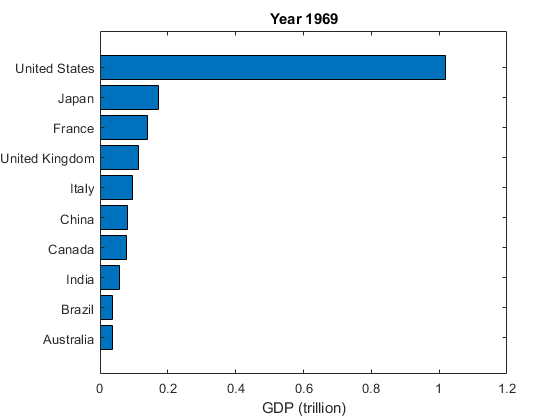

In [7]:
% extract the top 10 GDP values, 1969 is icol=5
Ydata = table2array(D3(1:10,5))/1e12;  % convert to trillion
Xdata = 1:10;
b = barh(Xdata,Ydata); 

% rank first on the top 
ax = gca;
ax.YDir = 'reverse';

% top ten country
c = D.CountryName(idx(1:10));
yticklabels(c)
xlabel('GDP (trillion)')
title(['Year 1969'])
    

这基本上就是我们要的bar图的样子了，不过需要稍作修饰。主要有两点：
* 各个bar条有各自的颜色
* 各个bar条顶部标识对应的数字

最开始给出的GIF中，各个国家的名字是按所属大洲采用不同颜色进行标示，并且整体没有边框。不过由于MATLAB的绘图局限，相对不那么容易实现，我们这里暂时先不做相应修改。

关于bar条的颜色，要想漂亮的话需要挑好看的配色方案。我们这里参考[ggplot](http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/)的配色。ggplot是R的一个可视化库，作图非常漂亮，配色对色盲的人友好，本色弱患者表示喜欢。

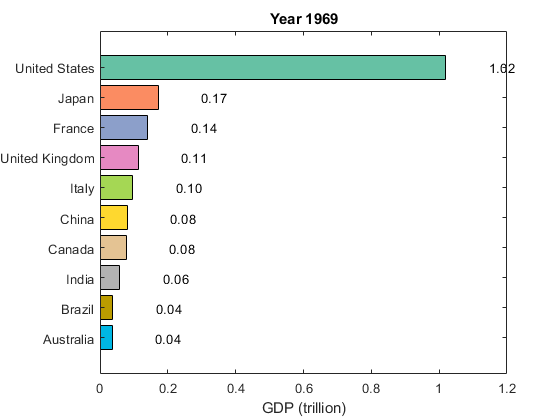

In [10]:
% color order from ggplot2
ggcorder = [
    102 194 165;
    252 141 98;
    141 160 203; 
    231 138 195;
    166 216 84;
    255 217 47;
    229 196 148; 
    179 179 179;
    188 157 0;
    0 184 229;
    ]/256;
    
b = barh(Xdata,Ydata); 

% rank first on the top 
ax = gca;
ax.YDir = 'reverse';

% top ten country
c = D.CountryName(idx(1:10));
yticklabels(c)
xlabel('GDP (trillion)')
title(['Year 1969'])
    
% change face color
b.FaceColor = 'flat';
b.CData = ggcorder;

% add text on top of bar
for ibar = 1:numel(Ydata)
    text(Ydata(ibar)+0.165,Xdata(ibar),num2str(Ydata(ibar),'%0.2f'),'HorizontalAlignment','center','VerticalAlignment','middle')
    
end
   

## 动图GIF绘制

完成了单帧的作图之后，要制作GIF，只需要一次对每一年的数据如上作图，然后将每一帧写进同一个图片文件就可以了。制作GIF的主要流程如下面的循环：

相比于上面绘制单个bar图的代码，需要增加更多的修饰保证GIF的效果：
* 设置统一的xlim，保证bar的长度是增加的
* 固定axes position，保证边框是固定的
* 每个国家绑定一个bar的颜色，这样可以跟踪国家名次的变化


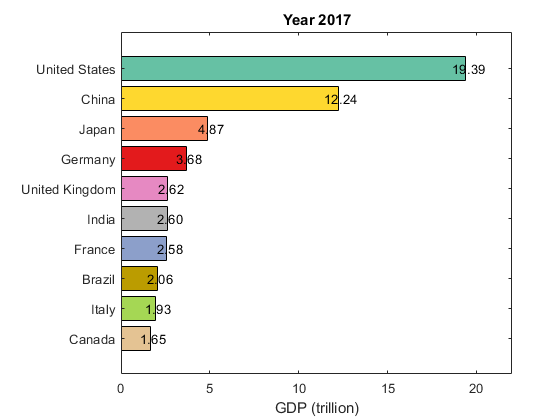

In [12]:
ggcorder = [102 194 165;
    252 141 98;
    141 160 203; 
    231 138 195;
    166 216 84;
    255 217 47;
    229 196 148; 
    179 179 179;
    188 157 0;
    0 184 229;
     ]/256;

h = figure;
axis tight manual
set(gcf,'color','w')
    
% axis tight manual % this ensures that getframe() returns a consistent size
filename = 'testAnimated.gif';
for n = 1969:2017
    rname = ['str2double_x' num2str(n) '_YR' num2str(n) '_'];
    [D3,idx] = sortrows(D2,rname,'descend');
    icol = find(contains(D3.Properties.VariableNames,rname)==1);
    Ydata = table2array(D3(1:10,icol))/1e12;
    c = D.CountryName(idx(1:10));
    
    if n==1969
        cinit = c;
    end
    Xdata=1:10;
    b = barh(Xdata,Ydata);
    b.FaceColor = 'flat';
    
    for ii=1:length(c)
        idx_c = find(contains(cinit,c{ii})==1);
        if isempty(idx_c)
            b.CData(ii,:) = [228 26 28]/256;
        else
            b.CData(ii,:) = ggcorder(idx_c,:);
        end
    end
    ax = gca;
    ax.YDir = 'reverse';
    yticklabels(c)
    xlabel('GDP (trillion)')
    title(['Year ' num2str(n)])
    xlim([0 22])
    
    ax=gca;
    ax.Position = [0.2160    0.1100    0.6990    0.8150];
    for ibar=1:numel(Ydata)
        text(Ydata(ibar)+0.165,Xdata(ibar),num2str(Ydata(ibar),'%0.2f'),...
               'HorizontalAlignment','center',...
               'VerticalAlignment','middle')
    end
    drawnow 
    % Capture the plot as an image 
      frame = getframe(h); 
      im = frame2im(frame); 
      [imind,cm] = rgb2ind(im,256); 
      % Write to the GIF File 
      if n == 1969 
          imwrite(imind,cm,filename,'gif', 'Loopcount',inf,'DelayTime',0.5); 
      else 
          imwrite(imind,cm,filename,'gif','WriteMode','append','DelayTime',0.5); 
      end 
end


我们最后得到的GIF图如下，每一帧之间的延迟时间稍微放慢了，边框保留了下来，同时字体未做修饰：
![Test](testAnimated.gif)

## 总结
简单总结一下，今天绘制这一GIF的过程中，涉及到以下内容：
* 用readtable读取复杂数据，并对数据进行适当的规整
* bar图的绘制，应用自定义配色方案
* GIF的绘制流程
